## Librerías:

In [13]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from torchvision.models import resnet50, resnet101, resnet152, ResNet50_Weights,ResNet101_Weights, ResNet152_Weights
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Visualizar una matriz de confusión para una etiqueta específica
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from SupportFunc.Loader import MultiLabelImageDataset
from SupportFunc.AdaptiveAttention import AdaptiveAttention, AdaptiveTransformerEncoderLayer
from SupportFunc.Visualization import plot_confusion_matrix, plot_train_val_curve

## Parámetros y funciones:

In [14]:
class AdaptiveAttentionClassifier(nn.Module):
    def __init__(self, image_feature_dim, num_classes):
        super(AdaptiveAttentionClassifier, self).__init__()
        self.image_embed = nn.Linear(image_feature_dim, 512)
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Proyección de características
        image_embeddings = self.image_embed(image_features)

        # Pasar por las capas del Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings.unsqueeze(1)).squeeze(1)

        # Clasificador final
        output = self.mlp(image_embeddings)
        return output


In [15]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 2
subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))

190


## Carga de datos:

### Selección de subset para pruebas:

In [16]:
train_1 = pd.read_csv(f'{data_directory}/train_data_1.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data_1.csv')

train_1 = train_1[train_1['ID'].isin(subset)]
test_1 = test_1[test_1['ID'].isin(subset)]

train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding = 'utf-8', index=False)
train_1.to_csv(f'{data_directory}/test_data_2.csv', encoding = 'utf-8', index=False)

In [17]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset y DataLoader
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Instanciar modelo:

In [18]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
#resnet = models.resnet101(weights=ResNet101_Weights.DEFAULT)  # Para ResNet101
#resnet = models.resnet152(weights=ResNet152_Weights.DEFAULT)  # Para ResNet152

# Congelar todas las capas inicialmente
for param in resnet.parameters():
    param.requires_grad = False

# Descongelar las capas que quieres ajustar (por ejemplo, 'layer4' o 'fc')
for param in resnet.layer4.parameters():  # Afinar el bloque final
    param.requires_grad = True
    
# Reemplazar la capa final con una capa adaptada a tu número de clases
num_classes = train_dataset[0][1].size(0)  # Obtener el número de clases desde el dataset
resnet.fc = nn.Identity()
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

model = AdaptiveAttentionClassifier(image_feature_dim=2048, num_classes=num_classes)
model = model.to(device)

# Optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0001)

In [19]:
#Comprobar que las dimensiones de salida de resnet sean consistentes con la siguiente capa
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
image_features = resnet(images)
print(image_features.shape)

torch.Size([16, 2048])


## Entrenamiento:

In [20]:
# Dividir el conjunto de datos en entrenamiento y validación (90%-10%)
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))), test_size=0.1, random_state=42
)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

# Entrenamiento
train_losses = list()
val_losses = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = resnet(images)  # Salida de ResNet
        outputs = model(image_features)  # Pasar por el modelo adaptativo
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:  # Cambiar a val_loader
            images, labels = images.to(device), labels.to(device)
            image_features = resnet(images)  # Salida de ResNet
            outputs = model(image_features)  # Pasar por el modelo adaptativo
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Guardar métricas de pérdida
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Imprimir métricas
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/2, Train Loss: 0.6713, Val Loss: 0.6376
Epoch 2/2, Train Loss: 0.5969, Val Loss: 0.5759


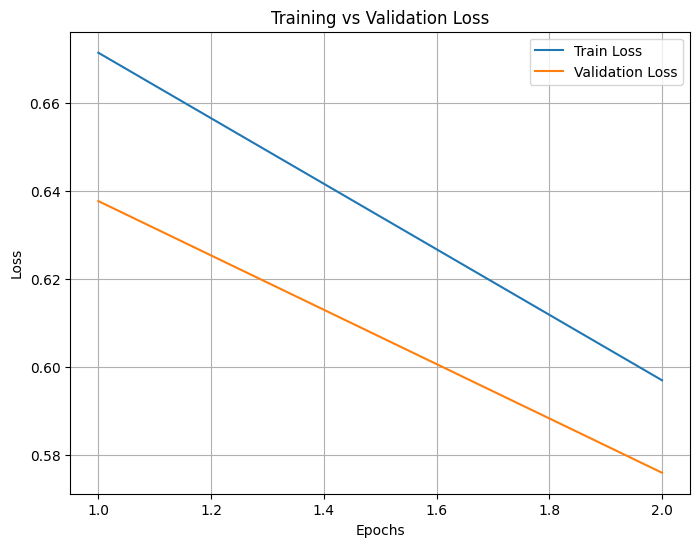

In [21]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

## Inferencia y métricas:

In [22]:
# Coloca el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = list()
all_preds = list()

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Extraer características con ResNet y pasar por el modelo
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

In [23]:
# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       0.71      0.67      0.69        43
      NORMAL       0.17      1.00      0.29        23
          MH       0.30      0.21      0.25        14
         ODC       0.17      0.68      0.28        19
        TSLN       1.00      0.20      0.33        10
        ARMD       0.00      0.00      0.00         5
          DN       0.00      0.00      0.00        15
         MYA       0.00      0.00      0.00         9
        BRVO       0.00      0.00      0.00         5
         ODP       0.00      0.00      0.00         2
        CRVO       0.00      0.00      0.00         2
         CNV       0.00      0.00      0.00         0
          RS       0.00      0.00      0.00         0
         ODE       0.00      0.00      0.00         2
          LS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00         5
         HTR       0.00      0.00      0

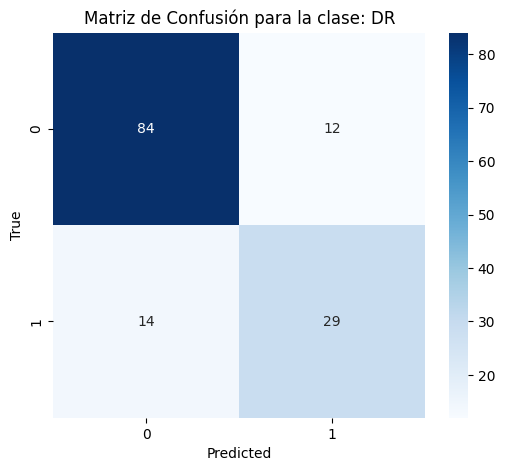

In [24]:
# Ejemplo: Visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]
plot_confusion_matrix(confusion_matrices[0], class_name)